In [1]:
# !pip install -q diffusers

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


Failed to download (trying next):
HTTP Error 400: Bad Request



100%|██████████| 9912422/9912422 [00:17<00:00, 568448.94it/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 400: Bad Request



100%|██████████| 28881/28881 [00:00<00:00, 134401.08it/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 400: Bad Request



100%|██████████| 1648877/1648877 [00:01<00:00, 1192163.42it/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 400: Bad Request



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]


Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw

input shape: torch.Size([8, 1, 28, 28])
labels: tensor([0, 8, 5, 8, 4, 9, 9, 4])


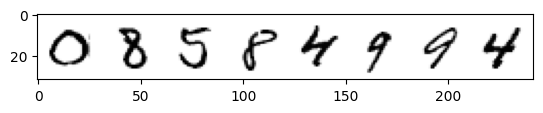

In [3]:
# load dataset and make dataloader
dataset = torchvision.datasets.MNIST(root="mnist/",
                                     train=True,
                                     transform=torchvision.transforms.ToTensor(),
                                     download=True)
train_loader = DataLoader(dataset=dataset, 
                          batch_size=8, 
                          shuffle=True)
x, y = next(iter(train_loader))
print('input shape:', x.shape)
print('labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')


In [17]:
print(len(dataset))
print(dataset[0][0].shape)

60000
torch.Size([1, 28, 28])


In [4]:
# corrupt data
def corrupt(x, amount):
    noise = torch.rand_like(x) # rand_like: return a tensor that sizes is input size, elements are uniform [0, 1]
    amount = amount.view(-1, 1, 1, 1) # view: reshape tensor
    return (1-amount) * x + amount * noise


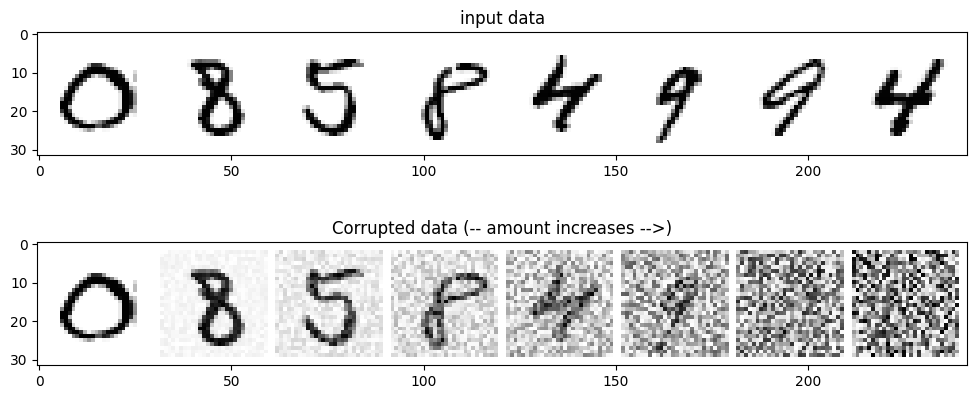

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')


In [8]:
# Basic UNet Network
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ])
        
        self.act = nn.ReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        
        for i, l in enumerate(self.up_layers): 
            if i > 0:
                x = self.upscale(x)
                x = h.pop() + x
            x = self.act(l(x))

        return x

net = BasicUNet()
print(net)
x = torch.rand(8, 1, 28, 28)
net(x).shape

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): ReLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)


torch.Size([8, 1, 28, 28])

In [10]:
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 1/3 | Average Loss: 0.0200
Finished epoch 2/3 | Average Loss: 0.0169
Finished epoch 3/3 | Average Loss: 0.0162


(0.0, 0.1)

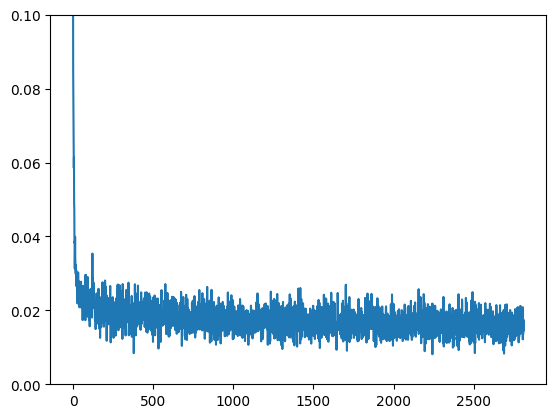

In [11]:
batch_size = 64
n_epochs = 3
train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

net = BasicUNet()
net.to(device)
# refer the loss function
loss_fn = nn.MSELoss()
# refer the optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# register the losses
losses = [] 
# train the model   
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x)
        
        loss = loss_fn(pred, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch+1}/{n_epochs} | Average Loss: {avg_loss:.4f}')
    
plt.plot(losses)
plt.ylim(0, 0.1)

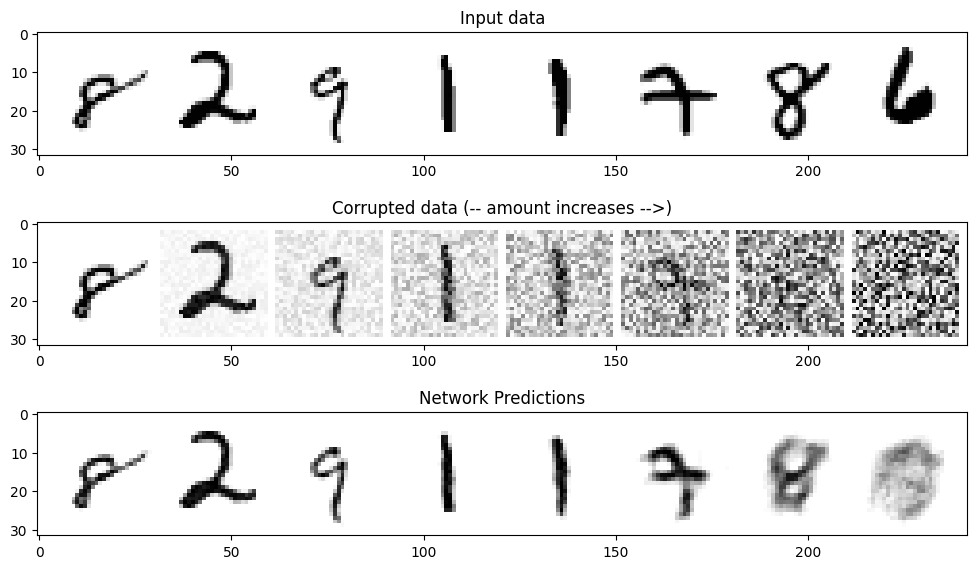

In [14]:
# visualize model performance on "noisy" input 
x, y = next(iter(train_dataloader))
x = x[:8]

# 在（0，1）区间选择退化量
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

# 得到模型的预测结果
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()
    
# 绘图
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1), cmap='Greys')

axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0,1), cmap='Greys')

axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0,1), cmap='Greys')


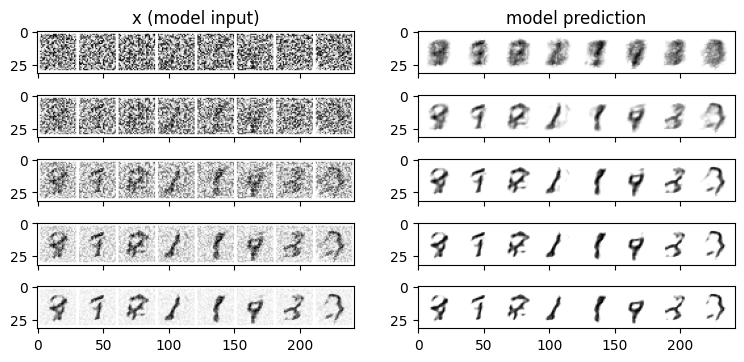

In [15]:
# sampling strategy
# Break down the sampling process into 5 steps
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)
    pred_output_history.append(pred.detach().cpu())
    
    mix_factor = 1/(n_steps-i)
    x = (1-mix_factor) * x + mix_factor * pred
    step_history.append(x.detach().cpu())
    
fig, axs = plt.subplots(n_steps, 2, figsize=(9,4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0,1), 
                    cmap='Greys')
    axs[i,1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0,1), 
                    cmap='Greys')

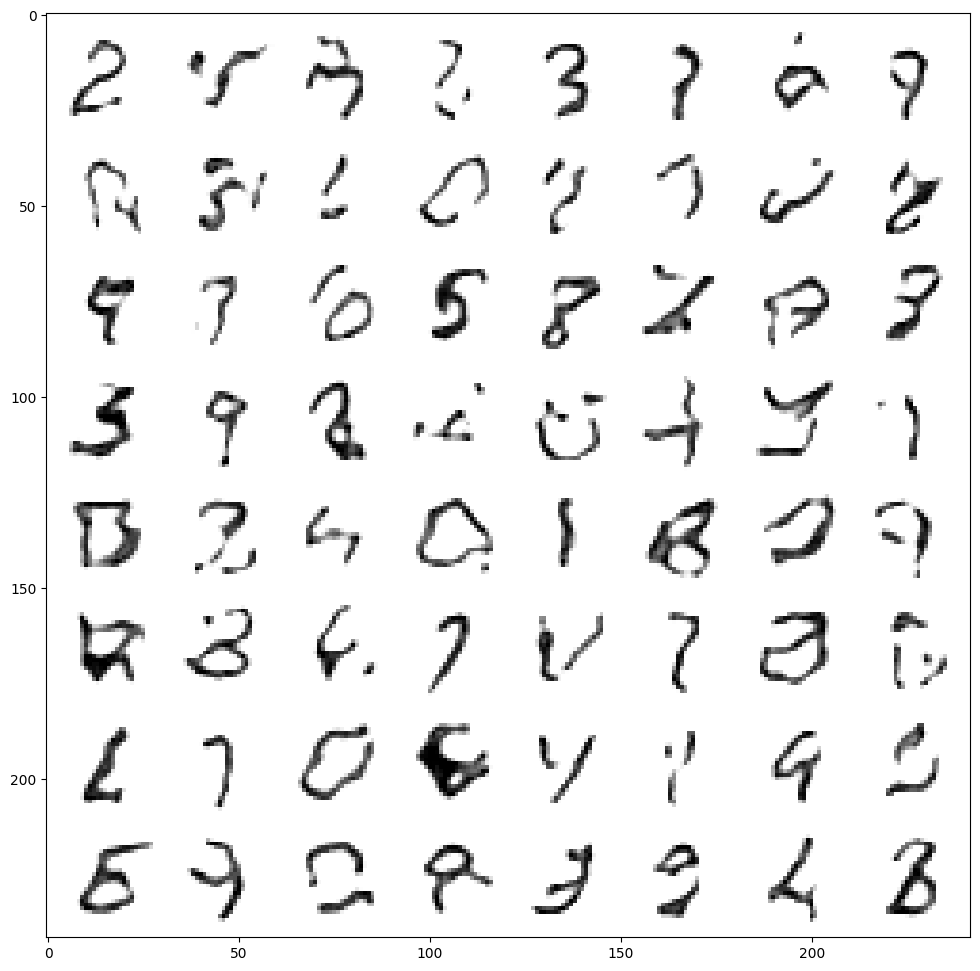

In [18]:
# Break down the sampling process into 40 steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    # noise_amount = torch.ones((x.shape[0],)).to(device) * (1-i/n_steps) 
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1/(n_steps-i)
    x = (1-mix_factor) * x + mix_factor * pred
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0,1), 
          cmap='Greys')

In [2]:
# New Model: UNet2DModel
model = UNet2DModel(sample_size=28,
                    in_channels=1,
                    out_channels=1,
                    layers_per_block=2,
                    block_out_channels=(32, 64, 64),
                    down_block_types=(
                        "DownBlock2D",
                        "AttnDownBlock2D",
                        "AttnDownBlock2D",
                    ),
                    up_block_types=(
                        "AttnUpBlock2D",
                        "AttnUpBlock2D",
                        "UpBlock2D",
                    ),
)

print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleLis

In [3]:
# totle parameters
sum([p.numel() for p in model.parameters()])

1707009